In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt

In [2]:
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정
# 하이퍼파라미터를 튜닝하기 위한 용도(흔들리면 무엇때문에 좋아졌는지 알기 어려움)
tf.set_random_seed(777)

In [3]:
def MinMaxScaler(data):
    # 데이터 모든숫자들을 최소 값만큼 뺀다.
    numerator = data - np.min(data, 0)
    # 최대값과 최소 값의 차이(A)를 구한다
    denominator = np.max(data, 0) - np.min(data, 0)
    # 너무 큰 값이 나오지 않도록 나눈다
    return numerator / (denominator + 1e-7)

In [4]:
# 하이퍼파라미터
seq_length = 7       # 1개 시퀀스의 길이(시계열데이터 입력 개수)
data_dim = 5         # Variable 개수
hidden_dim = 10      # 각 셀의 출력 크기
output_dim = 1       # 결과 분류 총 수
learning_rate = 0.01 # 학습률
epoch_num = 500      # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)

In [5]:
# 데이터를 로딩한다.
# 시작가, 고가, 저가, 거래량, 종가
xy = np.loadtxt('stock_daily_price.csv', delimiter=',')

In [6]:
# 데이터 전처리
xy = xy[::-1] # 제일앞이 뒤로, 제일뒤가 앞으로 순서를 뒤집는다.
print("xy[0][0]: ", xy[0][0])
xy = MinMaxScaler(xy)
print("xy[0][0]: ", xy[0][0])
x = xy
y = xy[:, [-1]] # 마지막 열이 정답(주식 종가)이다.
print("x[0]: ", x[0])
print("y[0]: ",y[0])

xy[0][0]:  568.00257
xy[0][0]:  0.21375105364038344
x[0]:  [0.21375105 0.20817981 0.19179183 0.00046608 0.1920924 ]
y[0]:  [0.1920924]


In [7]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]] -> [0.13289962]


In [8]:
# 학습용/테스트용 데이터 생성
# 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [9]:
# 텐서플로우 플레이스홀더 생성
# 학습용/테스트용으로 X, Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 7, 5), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [10]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성한다.
    # num_units: 각 Cell 출력 크기
    # forget_bias: The bias added to forget gates.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    # cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.sigmoid)
    # cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, forget_bias=0.8, state_is_tuple=True, activation=tf.tanh)
    return cell

# 몇개의 층으로 쌓인 Stacked RNNs 생성, 여기서는 1개층만
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(1)], state_is_tuple=True)

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

Y_pred = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_dim, activation_fn=None)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 7, 10), dtype=float32)


In [11]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE(Root Mean Square Error)
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

[step: 0 loss: 19.87626838684082
[step: 1 loss: 3.8608577251434326
[step: 2 loss: 6.604065418243408
[step: 3 loss: 9.303614616394043
[step: 4 loss: 5.918629169464111
[step: 5 loss: 2.631295680999756
[step: 6 loss: 1.99057137966156
[step: 7 loss: 3.058718204498291
[step: 8 loss: 4.0336408615112305
[step: 9 loss: 3.966428518295288
[step: 10 loss: 2.9845733642578125
[step: 11 loss: 1.798893690109253
[step: 12 loss: 1.141347050666809
[step: 13 loss: 1.3105800151824951
[step: 14 loss: 1.967499017715454
[step: 15 loss: 2.4306461811065674
[step: 16 loss: 2.3120200634002686
[step: 17 loss: 1.7901421785354614
[step: 18 loss: 1.3099344968795776
[step: 19 loss: 1.1691991090774536
[step: 20 loss: 1.3503330945968628
[step: 21 loss: 1.6220730543136597
[step: 22 loss: 1.7513400316238403
[step: 23 loss: 1.6524310111999512
[step: 24 loss: 1.403542160987854
[step: 25 loss: 1.1639316082000732
[step: 26 loss: 1.0620697736740112
[step: 27 loss: 1.1186668872833252
[step: 28 loss: 1.2466274499893188
[step: 2

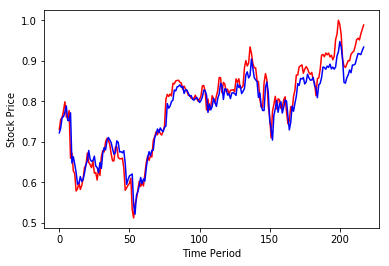

In [12]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # 학습한다
    for epoch in range(epoch_num):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {} loss: {}".format(epoch, step_loss))
    
    # 테스트한다
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    
    # 테스트용 데이터 기준으로 측정지표 rmse를 산출한다
    rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
    print("rmse: ", rmse_val)
    
    plt.plot(testY, 'r')
    plt.plot(test_predict, 'b')
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()